In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from pathlib import Path
import os

isKaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if isKaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile, kaggle
    path = Path('titanic')
    if not path.exist():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
from fastai.tabular.all import *
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

# Data Preparation



In [4]:
df = pd.read_csv(path/'train.csv')

When you do everything from scratch; a lot of effort is required in feature engineering (creating dummy variables, normalization, missing values and so on). Framework like fastai works all this for you.

In [5]:
def add_features(df):
#     df = add
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A='ABC', B='ABC', C='ABC', D='DE', E='DE', F='FG', G='FG'))
    df['Family'] = df.SibSp + df.Parch
    df['Alone'] = df.Family == 0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr='Mr', Miss='Miss', Mrs='Mrs', Master='Master'))
#     print(df)
add_features(df)

Splitting into training and validation set

In [6]:
splits = RandomSplitter(seed=42)(df)

In [7]:
splits

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [8]:
# Getting data ready for the training 
dls = TabularPandas(df,
                    splits=splits,
                    procs = [Categorify, FillMissing, Normalize],
                    cat_names= ["Sex", "Pclass", "Embarked", "Deck", "Title"],
                    cont_names = ['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
                    y_names = 'Survived',
                    y_block = CategoryBlock(),
                   ).dataloaders(path='')

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


# Train the model
Data + Model = Learner


In [9]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

We didn't modified the random coefficients and adjust those for the layers

SuggestedLRs(slide=0.05754399299621582, valley=0.013182567432522774)

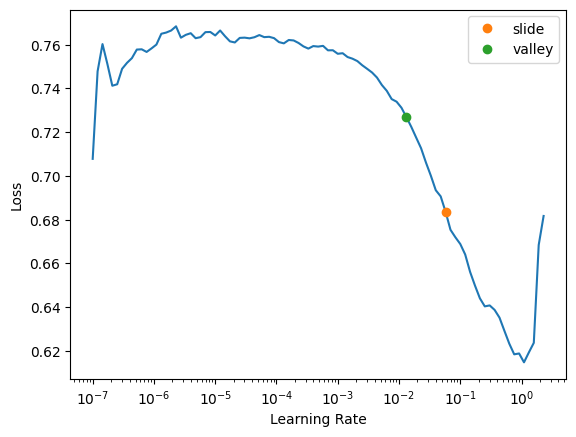

In [10]:
learn.lr_find(suggest_funcs=(slide, valley))

In [11]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.577146,0.582949,0.606742,00:00
1,0.510818,0.498523,0.786517,00:00
2,0.467023,0.459841,0.797753,00:00
3,0.439957,0.468547,0.797753,00:00
4,0.427232,0.415261,0.825843,00:00
5,0.416340,0.437362,0.820225,00:00
6,0.408347,0.413253,0.848315,00:00
7,0.400442,0.406075,0.803371,00:00
8,0.397265,0.443730,0.820225,00:00
9,0.392389,0.432267,0.831461,00:00


# Submitting to kaggle


In [12]:
test_df = pd.read_csv(path/'test.csv')
test_df['Fare'] = test_df.Fare.fillna(0)
add_features(test_df)

In [13]:
test_dl = learn.dls.test_dl(test_df)

/opt/conda/lib/python3.10/site-packages/fastai/tabular/core.py:312: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


In [14]:
preds,_ = learn.get_preds(dl=test_dl)
preds[:5], _

(tensor([[0.8755, 0.1245],
         [0.8073, 0.1927],
         [0.9635, 0.0365],
         [0.9113, 0.0887],
         [0.3139, 0.6861]]),
 None)

In [15]:
test_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = test_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [16]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
